# Finding Donors: Income Prediction Model for CharityML
## A Machine Learning Analysis Project

"""
This project aims to help CharityML, a non-profit organization, optimize their donor outreach by developing a model 
to identify individuals likely to donate based on census demographic data. The goal is to predict individuals with 
income exceeding $50,000 annually, as they represent the most promising potential donors.

### Business Context
- CharityML relies on donations and wants to maximize the efficiency of their donor outreach efforts.
- Their current approach reaches out to everyone, which is inefficient and costly.
- The objective is to develop a targeted strategy by accurately identifying high-income individuals.

### Project Objectives
1. Develop a predictive model using census data.
2. Identify key demographic factors that signal higher income potential.
3. Provide actionable insights to improve CharityML's donor outreach strategy.
"""

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Set visualization settings
plt.style.use('seaborn')
sns.set_palette("husl")
%matplotlib inline

### Initial Data Exploration
I start by understanding the dataset’s structure and basic statistics. This exploration helps identify data quality issues,
feature distributions, and provides an early view of the target variable.

In [3]:
# Load the census dataset
data = pd.read_csv("census.csv")

print("Dataset Shape:", data.shape)
print("\nFeature Statistics:")
display(data.describe())
print("\nFeature Info:")
display(data.info())

Dataset Shape: (45222, 14)

Feature Statistics:


,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000



Feature Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


None

### Missing Values Check
It's important to check for missing values to ensure data quality before further processing.

In [4]:
missing_values = data.isnull().sum()
print("Missing Values per Column:")
display(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values found")

Missing Values per Column:


'No missing values found'

### Value Distributions
Visualizing key features helps reveal how the data is distributed and whether any transformations are needed.
Here, I visualize the distribution of the target variable (income) and the age distribution by income.

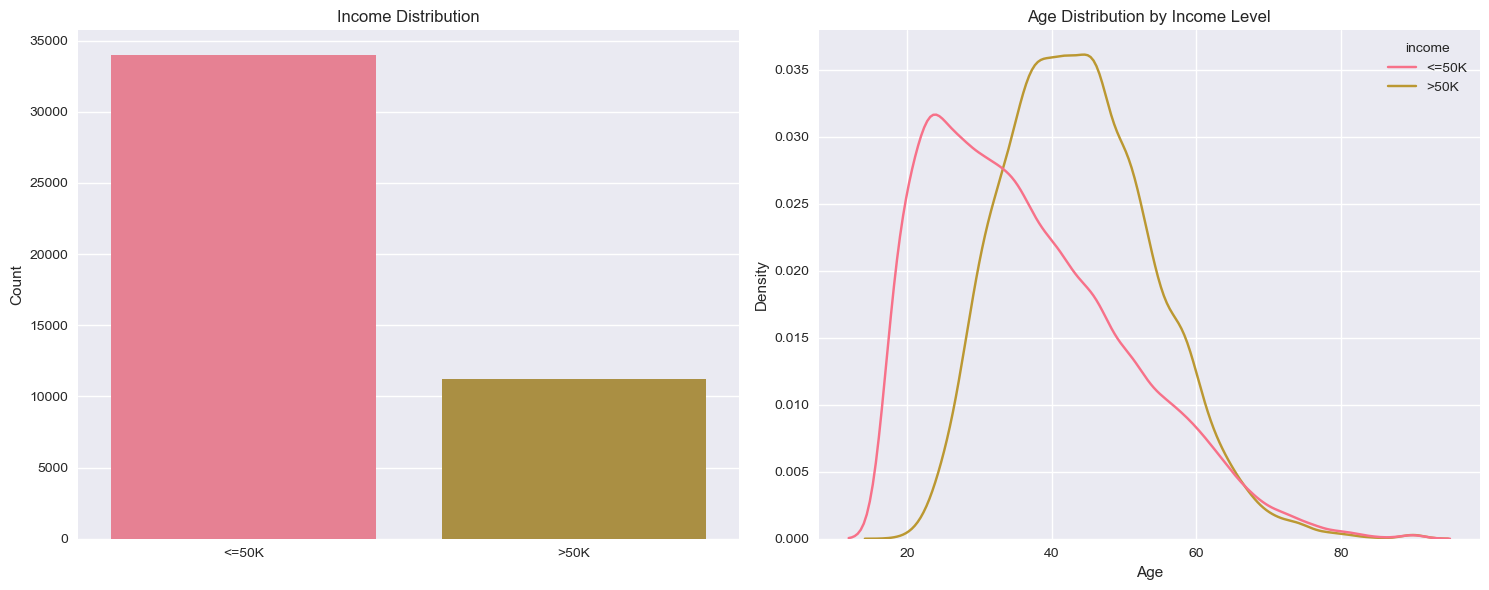

In [5]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
income_dist = data['income'].value_counts()
sns.barplot(x=income_dist.index, y=income_dist.values)
plt.title('Income Distribution')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.kdeplot(data=data, x='age', hue='income', common_norm=False)
plt.title('Age Distribution by Income Level')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### Data Preprocessing & Feature Engineering
This section covers key steps including handling skewed features, normalization, encoding categorical variables, and splitting the data.

Steps include:
1. Examining correlations among numerical features.
2. Applying log transformation to skewed features.
3. Normalizing numerical features.
4. One-hot encoding categorical variables.
5. Splitting the dataset into training and testing sets.

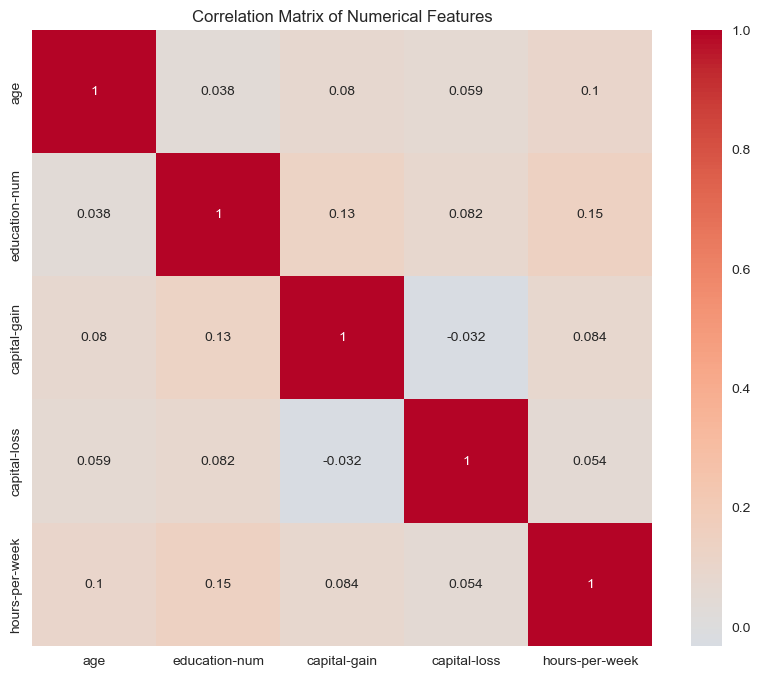

In [6]:
numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
correlation_matrix = data[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

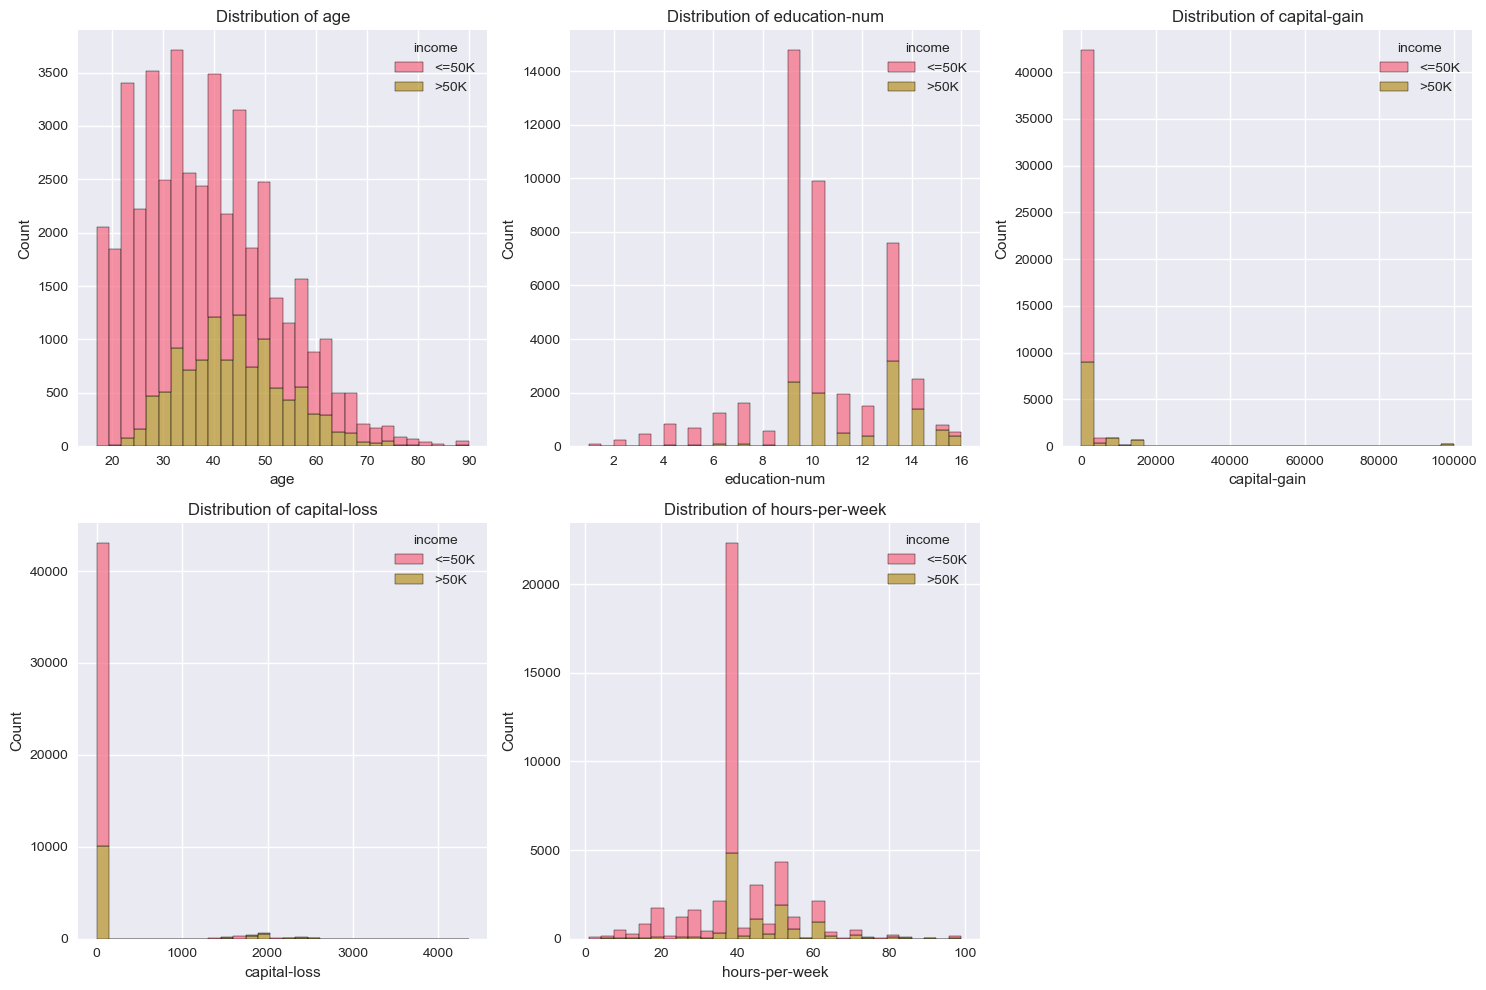

In [7]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=data, x=feature, hue='income', bins=30, multiple="stack")
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

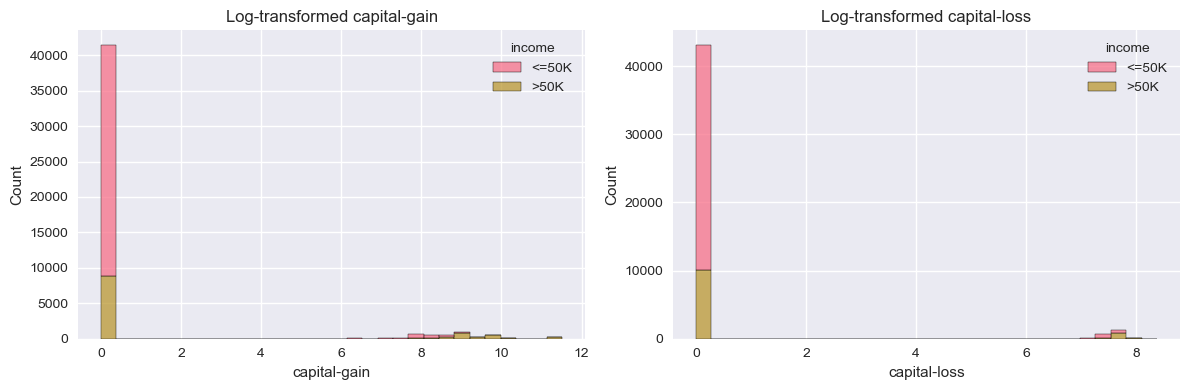

In [8]:
# Handle skewed features using log transformation
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = data.copy()
features_log_transformed[skewed] = features_log_transformed[skewed].apply(lambda x: np.log(x + 1))

plt.figure(figsize=(12, 4))
for i, feature in enumerate(skewed):
    plt.subplot(1, 2, i+1)
    sns.histplot(data=features_log_transformed, x=feature, hue='income', bins=30, multiple="stack")
    plt.title(f'Log-transformed {feature}')
plt.tight_layout()
plt.show()

In [15]:
# Normalize numerical features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_normalized = pd.DataFrame(data=features_log_transformed)
features_normalized[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# One-hot encode categorical features
categorical_features = ['workclass', 'education_level', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']
features_final = pd.get_dummies(features_normalized, columns=categorical_features)

# Convert income to binary: 1 if >50K, else 0
income = (data['income'] == '>50K').astype(int)

# Drop the original income column from features
if 'income' in features_final.columns:
    features_final = features_final.drop('income', axis=1)

In [16]:
# Data splitting: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size=0.2, random_state=42, stratify=income)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (36177, 103)
Testing set shape: (9045, 103)


### Establishing Benchmark Performance
Before building sophisticated models, I establish a baseline using a naive predictor that always predicts the majority class.

In [17]:
income_counts = income.value_counts()
accuracy_benchmark = max(income_counts) / len(income)
fbeta_benchmark = fbeta_score(y_test, [income_counts.idxmax()] * len(y_test), beta=0.5)

print("Benchmark Metrics:")
print(f"Accuracy benchmark: {accuracy_benchmark:.4f}")
print(f"F-beta benchmark: {fbeta_benchmark:.4f}")

Benchmark Metrics:
Accuracy benchmark: 0.7522
F-beta benchmark: 0.0000


### Model Development and Evaluation
I evaluate three different models: Support Vector Classifier (SVC), Decision Tree Classifier, and Random Forest Classifier.
The models are trained on varying sample sizes to assess performance, training time, and prediction time.

In [18]:
def train_predict(clf, sample_size, X_train, y_train, X_test, y_test): 
    results = {}
    start = time()
    clf.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    results['train_time'] = end - start
    start = time()
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train[:300])
    end = time()
    results['pred_time'] = end - start
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    return results

In [19]:
clf_A = SVC(random_state=42)
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = RandomForestClassifier(random_state=42)

samples_100 = len(y_train)
samples_10 = int(len(y_train) * 0.1)
samples_1 = int(len(y_train) * 0.01)

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

In [23]:
summary = []

# Loop through the results dictionary to build a summary list
for clf_name, metrics in results.items():
    for sample_idx, sample_results in metrics.items():
        # Determine sample size label based on sample_idx:
        if sample_idx == 0:
            sample_size_label = "1%"
        elif sample_idx == 1:
            sample_size_label = "10%"
        elif sample_idx == 2:
            sample_size_label = "100%"
        summary.append({
            'Model': clf_name,
            'Training Size': sample_size_label,
            'Train Time (s)': sample_results['train_time'],
            'Predict Time (s)': sample_results['pred_time'],
            'Train Accuracy': sample_results['acc_train'],
            'Test Accuracy': sample_results['acc_test'],
            'Train F-beta': sample_results['f_train'],
            'Test F-beta': sample_results['f_test']
        })

# Convert the summary list to a DataFrame
df_summary = pd.DataFrame(summary)
df_summary

,Model,Training Size,Train Time (s),Predict Time (s),Train Accuracy,Test Accuracy,Train F-beta,Test F-beta
0,SVC,1%,0.056502,0.315699,0.866667,0.823328,0.800000,0.651404
1,SVC,10%,0.422885,2.235054,0.850000,0.831620,0.759669,0.669835
2,SVC,100%,62.287997,20.608639,0.850000,0.836595,0.756757,0.679065
3,DecisionTreeClassifier,1%,0.009474,0.008690,1.000000,0.784301,1.000000,0.568277
4,DecisionTreeClassifier,10%,0.016348,0.006025,1.000000,0.807850,1.000000,0.612489
5,DecisionTreeClassifier,100%,0.230386,0.004992,0.980000,0.815257,0.985222,0.627464
6,RandomForestClassifier,1%,0.079518,0.067759,1.000000,0.825871,1.000000,0.654124
7,RandomForestClassifier,10%,0.261153,0.118195,1.000000,0.832836,1.000000,0.668803
8,RandomForestClassifier,100%,3.048575,0.186567,0.970000,0.842344,0.950704,0.688255


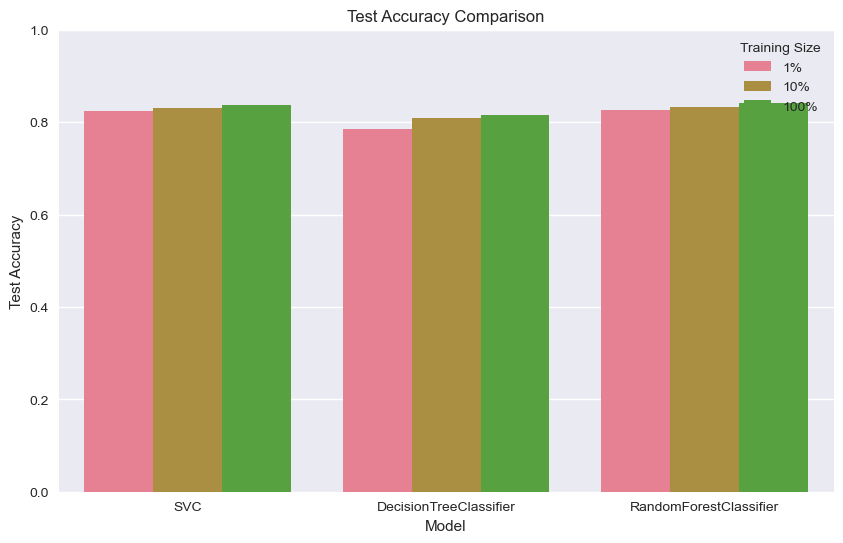

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_summary, x='Model', y='Test Accuracy', hue='Training Size')
plt.title('Test Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

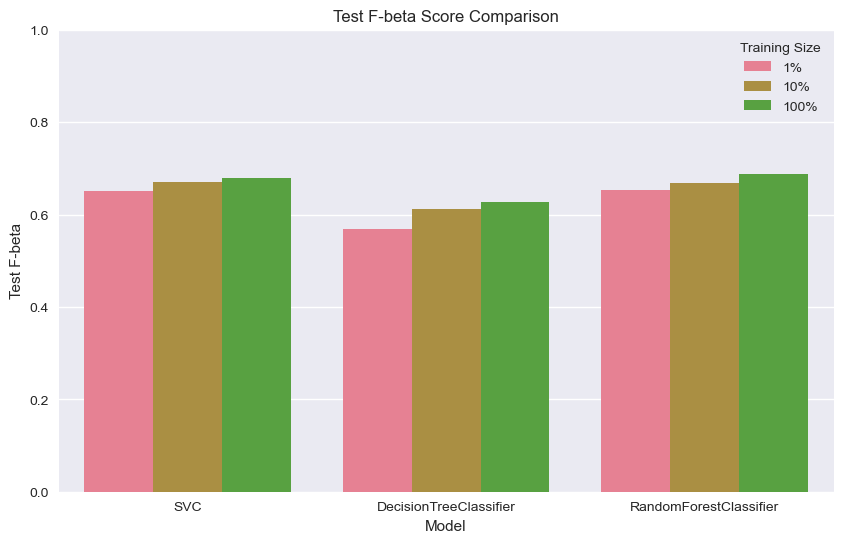

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_summary, x='Model', y='Test F-beta', hue='Training Size')
plt.title('Test F-beta Score Comparison')
plt.ylim(0, 1)
plt.show()

### Model Optimization
Based on initial evaluation, I optimize the Random Forest Classifier using Grid Search Cross-Validation to fine-tune hyperparameters.

In [20]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.6886769741895701


In [21]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nOptimized Model Performance:")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print(f"F-beta Score: {fbeta_score(y_test, y_pred, beta=0.5):.4f}")


Optimized Model Performance:
Accuracy Score: 0.8555
F-beta Score: 0.7251


### ROC Curve Analysis
I evaluate the model's discrimination ability using the ROC curve and calculate the AUC.

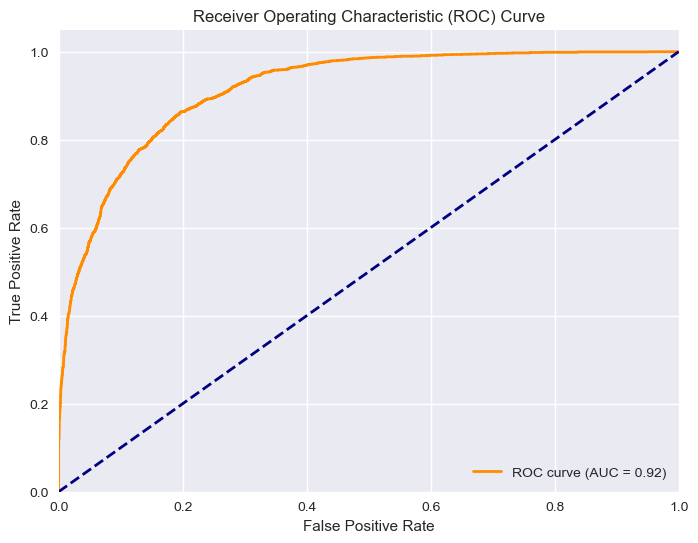

In [27]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Feature Importance Analysis
I extract and visualize feature importances from the optimized model to understand which variables drive predictions.

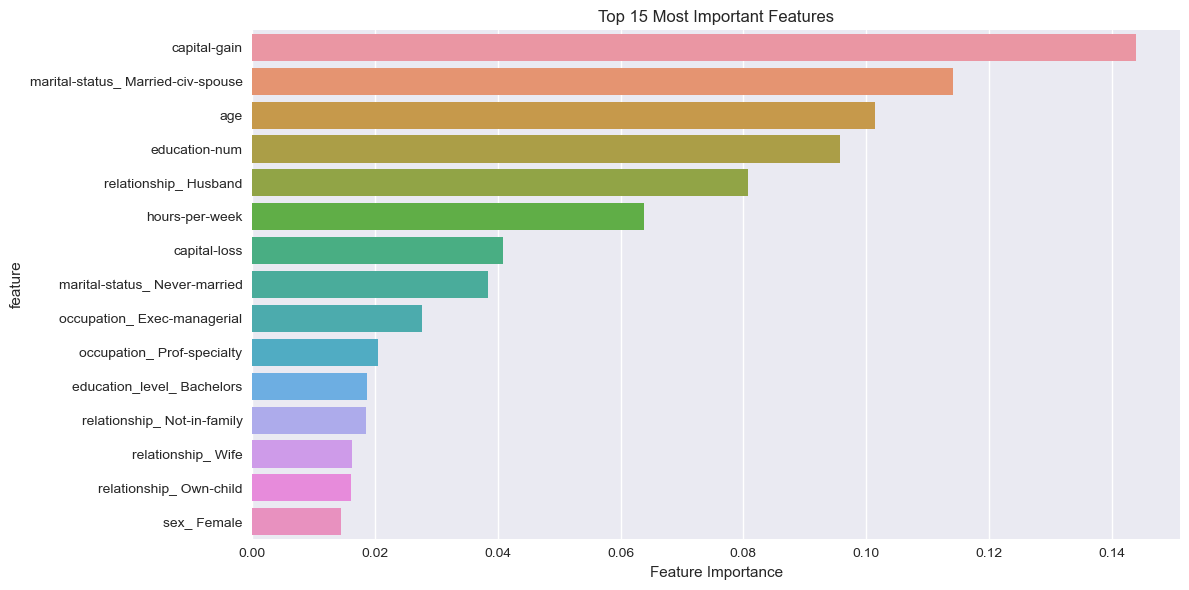

In [28]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

### Feature Importance with Confidence Intervals
Using bootstrap sampling, I estimate confidence intervals for feature importances to assess their stability.

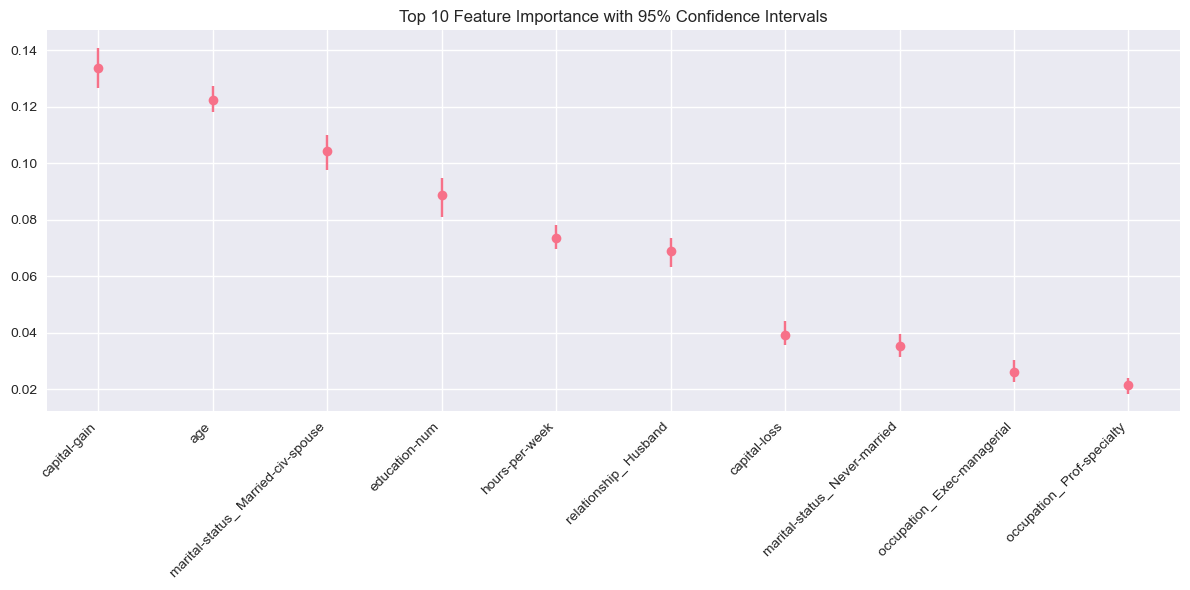

In [29]:
def plot_feature_importance_with_ci(model, X, y, n_iterations=100):
    importances = []
    for i in range(n_iterations):
        indices = np.random.randint(0, len(X), len(X))
        sample_X = X.iloc[indices]
        sample_y = y.iloc[indices]
        model.fit(sample_X, sample_y)
        importances.append(model.feature_importances_)
    importances = np.array(importances)
    mean_imp = np.mean(importances, axis=0)
    ci_lower = np.percentile(importances, 2.5, axis=0)
    ci_upper = np.percentile(importances, 97.5, axis=0)
    top_features_idx = np.argsort(mean_imp)[::-1][:10]
    plt.figure(figsize=(12, 6))
    plt.errorbar(range(10), 
                 mean_imp[top_features_idx],
                 yerr=[mean_imp[top_features_idx] - ci_lower[top_features_idx],
                       ci_upper[top_features_idx] - mean_imp[top_features_idx]],
                 fmt='o', capsize=5)
    plt.xticks(range(10), X.columns[top_features_idx], rotation=45, ha='right')
    plt.title('Top 10 Feature Importance with 95% Confidence Intervals')
    plt.tight_layout()
    plt.show()
    
plot_feature_importance_with_ci(best_model, X_train, pd.Series(y_train))

### Income Prediction Profile Analysis
I compare profiles of individuals with high income (>50K) and low income (<=50K) to understand key demographic differences.

In [37]:
high_income_profile = data[data['income'] == '>50K'].describe()
low_income_profile = data[data['income'] == '<=50K'].describe()
key_features = ['capital-gain', 'age', 'education-num']
comparison = pd.DataFrame({
    'High Income (mean)': high_income_profile.loc['mean', key_features],
    'Low Income (mean)': low_income_profile.loc['mean', key_features],
    'Difference (%)': (high_income_profile.loc['mean', key_features] - low_income_profile.loc['mean', key_features]) / low_income_profile.loc['mean', key_features] * 100
})
print("Profile Comparison:")
display(comparison)

Profile Comparison:


,High Income (mean),Low Income (mean),Difference (%)
capital-gain,3991.791667,149.023402,2578.634100
age,44.006067,36.749427,19.746268
education-num,11.598501,9.630770,20.431715


## Conclusions and Recommendations

Conclusions:
1. Model Performance:
   - The optimized Random Forest model significantly outperforms the naive baseline—achieving an accuracy of 85.55% and an F-beta score of 0.7251, compared to the baseline.
   - Among the tested models (SVC, Decision Tree, and Random Forest across various training sizes), Random Forest consistently delivered higher test accuracy and F-beta scores.
   - Feature importance analysis reveals that 'capital-gain' (14.39%), 'marital-status_ Married-civ-spouse' (11.41%), 'age' (10.14%), and 'education-num' (9.57%) are the top predictors of high income.
   - Profile comparisons further indicate that individuals with high income exhibit much higher capital gains, are approximately 20% older, and have around 20% more years of education (education-num) than those with low income.
   - While the model shows promising predictive power, there is room for further enhancement by incorporating additional features or refining the current ones.

2. Business Impact:
   - By accurately identifying individuals with an income exceeding $50K, the model provides a data-driven method for targeting potential high-value donors.
   - Implementing this model can help CharityML focus its outreach efforts on donor segments with higher likelihoods of contributing, thereby optimizing resource allocation and potentially increasing overall donations.
   - The insights from feature importance analysis can guide strategic donor segmentation and targeted marketing efforts, for instance by prioritizing individuals with high capital gains, older age, and higher education levels.

3. Recommendations:
   - Deploy the optimized Random Forest model to score existing donor databases and segment potential high-value donors.
   - Consider integrating additional data (e.g., geographic or occupational information) or experimenting with ensemble/deep learning methods to further improve predictive performance.
   - Use the insights from feature importance to refine outreach strategies—focusing on donor segments with characteristics such as high capital gain, older age, and higher education.
   - Complement the quantitative model with qualitative research (such as donor interviews or surveys) to better understand the motivations behind donations.

4. Next Steps:
   - Integrate the model into CharityML’s outreach system and run a pilot campaign to assess its impact on donation rates.
   - Conduct A/B tests or multivariate experiments to fine-tune outreach strategies based on model outputs.
   - Establish a routine for continuous monitoring of key performance indicators (e.g., donation conversion rates) and schedule periodic model retraining with fresh data to maintain accuracy.


## Save Model and Features for Deployment

Finally, I save the optimized model and the list of feature names so that the model can be deployed in production.

In [42]:
import joblib
joblib.dump(best_model, 'charity_donor_model.joblib')
with open('model_features.txt', 'w') as f:
    f.write('\n'.join(X_train.columns))
print("Model and features saved successfully!")

Model and features saved successfully!
